In [1]:
import math as m
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from copy import deepcopy
import time

In [2]:
class Sparrow:
    def __init__(
        self, 
        u: List[float], 
        f: float
             ):
        self.u = u
        self.f = f
        
class SparrowSwarm:
    def __init__(
        self,
        swarm_size: int,
        dim: int,
        m_capacity: float,
        max_loop_number: float,
        search_time: float,
        fragment: float,
        intensity_process: float,
        leader_step: float,
        reduction: float,
        recovery: float,
        levi_parameter: float,
        c1: float,
        c2: float,
        c3: float,
        min_area: float,
        func_num: int,
                 ):
        self.swarm_size = swarm_size
        self.dim = dim
        self.u_dim = dim-1
        self.m_capacity = m_capacity
        self.max_loop_number = max_loop_number
        self.search_time = search_time
        self.fragment = fragment
        self.step_integration = search_time / fragment
        self.intensity_process = intensity_process
        self.leader_step = leader_step
        self.reduction = reduction
        self.recovery = recovery
        self.levi_parameter = levi_parameter
        self.area_radius = 0
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.min_area = min_area
        self.rk = 1
        
        
        self.current_iter = 0
        
        self.exact = 0
        self.function_name = ''
        self.func_num = func_num
        
        self.population = []
        self.memory = []
        self.pool = []
        self.vector_f = []
        self.vector_sigma = []
        self.best_all_iters = []
        self.best_leaders = []
        self.best_local = []

        self.euclid_list = []
        self.area_new = []
        
        self.best_x1 = []
        
    #__________MINIMIZATION____________
        
    def init_area(self, control):
        self.area = [np.array([-1, 1]) for i in range(self.u_dim)] # было N_step - 1 вместо u.dim
        self.area_new = deepcopy(self.area)
        self.exact = control.ExactI()

        
        
    def form_first_pop(self, control):
        self.population.clear()
        for i in range(self.swarm_size):
            coordinate = np.array([np.random.rand() * (self.area[j][1] - self.area[j][0]) + self.area[j][0] \
                          for j in range(self.u_dim)])
            sparrow = Sparrow(coordinate, 0)
            self.population.append(sparrow)
            
            
    # best in abs x_j_best
    def find_best_all_iters(self, loop_id):
        if loop_id == 0:
            for i in range(1, self.swarm_size):
                self.best_all_iters.append(Sparrow(deepcopy(self.population[i].u), self.population[i].f))
                
        else:
            for i in range(1, self.swarm_size):
                if self.best_all_iters[i].f > self.population[i].f:
                    self.best_all_iters[i].f = self.population[i].f
                    self.best_all_iters[i].u = deepcopy(self.population[i].u)
    
    
    # best in pop x_best
    def find_leader(self):
        return min(self.population, key=lambda sparrow: sparrow.f)
    
    
    # best local x_j_local
    def find_best_local(self, leader_index):
        self.best_local.clear()
        for i in range(self.swarm_size):
            if i != leader_index:
                sparrow = Sparrow(deepcopy(self.population[i].u), self.population[i].f)
                for j in range(self.swarm_size):
                    if i!= j:
                        if np.linalg.norm(np.array(self.population[j].u) - np.array(self.population[i].u)) <= self.area_radius:
                            if sparrow.f > self.population[j].f:
                                sparrow.u = deepcopy(self.population[j].u)
                                sparrow.f = self.population[j].f
                self.best_local.append(sparrow)
        
        
    
    def calc_f_sigma(self):
        #check the best_local - index
        self.vector_f.clear()
        self.vector_sigma.clear()
        for i in range(1, self.swarm_size):
            r1 = np.random.uniform(0, 1)
            r2 = np.random.uniform(0, 1)
            r3 = np.random.uniform(0, 1)
            numb_last = len(self.best_leaders) - 1
            best_leaders_curr = np.array(self.best_leaders[numb_last].u) - np.array(self.population[i].u)

            best_all_iter_curr = np.array(self.best_all_iters[i - 1].u) - np.array(self.population[i].u)
            
            best_loc_curr = np.array(self.best_local[i - 1].u) - np.array(self.population[i].u)
            
            tmp_f = self.c1 * r1 * best_leaders_curr
            tmp_sigma = self.c2 * r2 * best_all_iter_curr + self.c3 * r3 * best_loc_curr
            self.vector_f.append(tmp_f)
            self.vector_sigma.append(tmp_sigma)
            
            
    def new_leader_location(self, iter_id):
        sparrow = Sparrow(deepcopy(self.population[0].u), self.population[0].f)
        check_obl = 0
        devide = self.swarm_size / 2
        dev_truncated = m.trunc(devide)
        in_while = True
        
        for i in range(self.u_dim):
            while_counter = 0
            
            while (in_while):
                in_while = False
                
                rr = np.random.uniform(0, 1) * (self.area_new[i][1] - self.area_new[i][0]) + self.area_new[i][0]
                theta = rr * 2 * m.pi
                ll = m.pow(abs(rr), 1 / self.levi_parameter)
                
                if i < dev_truncated:
                    xi = ll * m.sin(theta)
                else:
                    xi = ll * m.cos(theta)
                
                check_obl = self.population[0].u[i] + (self.leader_step / (iter_id + 1)) * xi
                if check_obl < self.area_new[i][0] or check_obl > self.area_new[i][1]:
                    in_while = True
                else:
                    in_while = False
                while_counter += 1
                if while_counter > 20:
                    in_while = False
                    
            if while_counter >= 20:
                if check_obl < self.area_new[i][0]:
                    sparrow.u[i] = self.area_new[i][0]
                if check_obl > self.area_new[i][1]:
                    sparrow.u[i] = self.area_new[i][1]
            sparrow.u[i] = self.population[0].u[i] + (self.leader_step / (iter_id + 1)) * xi
            
        self.population[0].u = deepcopy(sparrow.u)
                    

    
    def new_swarm_location(self, rk):
        
        for i in range(self.u_dim):
            self.area_new[i][0] = self.population[0].u[i] - rk * (self.area[i][1] - self.area[i][0]) * 0.5
            self.area_new[i][1] = self.population[0].u[i] + rk * (self.area[i][1] - self.area[i][0]) * 0.5
            
        for i in range(self.u_dim):
            if self.area_new[i][0] < self.area[i][0]:
                self.area_new[i][0] = self.area[i][0]
            if self.area_new[i][1] > self.area[i][1]:
                self.area_new[i][1] = self.area[i][1]
        
        for i in range(self.swarm_size):
            self.population[i].u = np.array([np.random.uniform(0, 1) * \
                                   (self.area_new[j][1] - self.area_new[j][0]) + self.area_new[j][0]\
                                   for j in range(self.u_dim)])

    
    def generate_pop_from_pool(self):
        self.population.clear()
        sparrow = Sparrow(deepcopy(self.pool[0].u), self.pool[0].f)
        self.population.append(sparrow)
        
        for i in range(self.u_dim):
            self.area_new[i][0] = sparrow.u[i] - self.rk * (self.area_new[i][1] - self.area_new[i][0]) * 0.5
            self.area_new[i][1] = sparrow.u[i] + self.rk * (self.area_new[i][1] - self.area_new[i][0]) * 0.5
        
        for i in range(self.u_dim):
            if self.area_new[i][0] < self.area[i][0]:
                self.area_new[i][0] = self.area[i][0]
            if self.area_new[i][1] > self.area[i][1]:
                self.area_new[i][1] = self.area[i][1]
        
        for i in range(1, self.swarm_size):
            sparr_u = []
            for j in range(self.u_dim):
                sparr_tmp = np.random.uniform(0, 1) * (self.area_new[j][1] - self.area_new[j][0]) + self.area_new[j][0]
                if sparr_tmp < self.area_new[j][0]:
                    sparr_tmp = self.area_new[j][0]
                if sparr_tmp > self.area_new[j][1]:
                    sparr_tmp = self.area_new[j][1]
                sparr_u.append(sparr_tmp)
            sparrow = Sparrow(sparr_u, 0)
            self.population.append(sparrow)
        
    
    
    def make_step(self, i, control):
        alpha1 = np.random.uniform(0, 1)
        alpha2 = np.random.uniform(0, 1)
        alpha = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 1)
        eta = (-2 * m.log(alpha1))**0.5 * m.cos(2 * m.pi * alpha2)
        
        sparr_u = []
        for j in range(self.u_dim):
            sparr_tmp = np.array(self.population[i].u[j]) + \
                        self.step_integration * self.vector_f[i-1][j] + \
                        (self.step_integration)**0.5 * self.vector_f[i-1][j] * eta
            
            if alpha < self.intensity_process * self.step_integration:
                sparr_tmp += theta
            
            # self.area_new - пустой список ВОТ ТАК
            if sparr_tmp < self.area_new[j][0]: 
                sparr_tmp = self.area_new[j][0]
            if sparr_tmp > self.area_new[j][1]:
                sparr_tmp = self.area_new[j][1]
            sparr_u.append(sparr_tmp)
        sparr_f = control.Functional(sparr_u)
        self.population[i].f = sparr_f
        self.population[i].u = deepcopy(sparr_u)
        

    
    def integration_gives_best(self, leader, control):
        best_sparrows_in_interg = []
        for i in range(1, self.swarm_size):
            best_integr = Sparrow(deepcopy(self.population[i].u), self.population[i].f)
                    
            for t in range(self.search_time):
                self.make_step(i, control)
                temp_result = control.Functional(self.population[i].u)
                if best_integr.f > temp_result:
                    best_integr.f = temp_result
                    best_integr.u = deepcopy(self.population[i].u)
                t += self.step_integration
            best_sparrows_in_interg.append(best_integr)
        best_sparrows_in_interg.append(leader)
        return best_sparrows_in_interg

    
    def work(self, control):
        start = time.monotonic()
        time.sleep(0.1)
        
        # step 1.2
        self.init_area(control)
        self.form_first_pop(control)
        
        # step 2: diffuse searching
        
        loop_id = 0
        not_first_loop = False
        while loop_id < self.max_loop_number:
            
            # step 3
            if not_first_loop:
                self.memory.clear()
                loop_id += 1
                self.rk = self.recovery
                self.area_new = deepcopy(self.area)
                self.pool.sort(reverse=False, key=lambda sparrow: sparrow.f)
                self.generate_pop_from_pool()
                
            # step 2.1
            iter_id = 0
            in_iter = True
            while in_iter:
                if iter_id != 0:
                    self.new_leader_location(iter_id)
                    self.new_swarm_location(self.rk)
                
                # step 2.2
                for i in range(self.swarm_size): 
                    coordinate = self.population[i].u
                    result = control.Functional(coordinate)
                    self.population[i].f = result
                
                # тут сортировка в порядке возрастания - ищем минимум pop[0]
                self.population.sort(reverse=False, key=lambda sparrow: sparrow.f)
               
                # step 2.3
                leader = Sparrow(deepcopy(self.population[0].u), self.population[0].f)
                
                #self.best_leaders.append(deepcopy(self.find_leader())) # find the one leader - that's right
                self.best_leaders.append(leader)
                self.find_best_all_iters(loop_id)
                self.find_best_local(0) # the list is refilled inside the function
                
                # step 2.4
                self.calc_f_sigma()
                
                # step 2.5 + 2.6
                best_sparrs_after_integr = self.integration_gives_best(leader, control)
                
                # step 2.7
                best_sparrs_after_integr.sort(reverse=False, key=lambda sparrow: sparrow.f)
                sparrow = Sparrow(deepcopy(best_sparrs_after_integr[0].u), best_sparrs_after_integr[0].f)
                self.memory.append(sparrow)
                
                # step 2.8
                self.rk = self.reduction * self.rk
                iter_id += 1
                if iter_id >= self.m_capacity:
                    in_iter = False
                if self.rk < self.min_area:
                    in_iter = False
            
            # step 3
            self.memory.sort(reverse=False, key=lambda sparrow: sparrow.f)
            self.pool.append(Sparrow(deepcopy(self.memory[0].u), self.memory[0].f))
            if loop_id == 0:
                not_first_loop = True
        self.pool.sort(reverse=False, key=lambda sparrow: sparrow.f)
        end = time.monotonic()
        
        self.make_best_x(self.pool[0].u)
        self.draw_plots()
        #print(self.pool[0].u, self.pool[0].f,'  Presize = ', self.exact,'  Error = ', (self.exact-self.pool[0].f))
        print('Approximate', self.pool[0].f,'  Presize = ', self.exact,'  Error = ', (self.exact-self.pool[0].f))
        print('u: ', self.pool[0].u)
        print('x: ', self.best_x1)
        
        print('work time : {:>9.2f}'.format(end-start))

    
    def make_best_x(self, u):
        self.best_x1.clear()
        self.best_x1.append(15)
        if u[0] >= 0:
            self.best_x1.append(np.power(self.best_x1[0], u[0]))
        else:
            tmp = np.power(self.best_x1[0], abs(u[0]))
            self.best_x1.append(1 / tmp)
        self.best_x1.append((1 + u[1]) * self.best_x1[1])
        self.best_x1.append(self.best_x1[2] + u[2])
        self.best_x1 = np.array(self.best_x1)
    
    def draw_plots(self):
        plt.figure(figsize=(20, 10))

        plt.subplot(1,2,1)
        #plt.plot(self.best_list[0].u, '.')
        plt.plot(self.pool[0].u, '.')
        plt.ylabel('u')
        plt.xlabel('t')

        plt.subplot(1,2,2)
        plt.plot(self.best_x1, '.')
        plt.ylabel('$x$')
        plt.xlabel('t')

        plt.show()
            

In [3]:
class DiscreteSystem:
    def __init__(
    self, 
    N_step: int,
    ):
        self.N_step = N_step # N is the dimention of the x, dim for u is the N-1

    def make_x(self, u):
        x1 = []
        u = np.array(u)
        x1.append(15)
        if u[0] >= 0:
            x1.append(np.power(x1[0], u[0]))
        else:
            tmp = np.power(x1[0], abs(u[0]))
            x1.append(1 / tmp)
        x1.append((1 + u[1]) * x1[1])
        x1.append(x1[2] + u[2])
        x1 = np.array(x1)
        return x1

    def Functional(self, u):
        x1 = []
        x1 = self.make_x(u)
        x1 = np.array(x1)

        return (x1[0]**2 + x1[1]**2 + (2 * x1[2]**2 + x1[3]**2) * np.exp(x1[1]**2)) * \
                            (50 + u[0]**2 + (u[1]**2 + u[2]**2) * np.exp(u[0]**2))**0.5

        
    def ExactI(self):
        return 1596.4796778

In [4]:
def print_some(list_):
    for indx in range(len(list_)):
        #print('iter: ',indx, '   ', list_[indx].u, list_[indx].f)
        print(list_[indx].u, list_[indx].f)

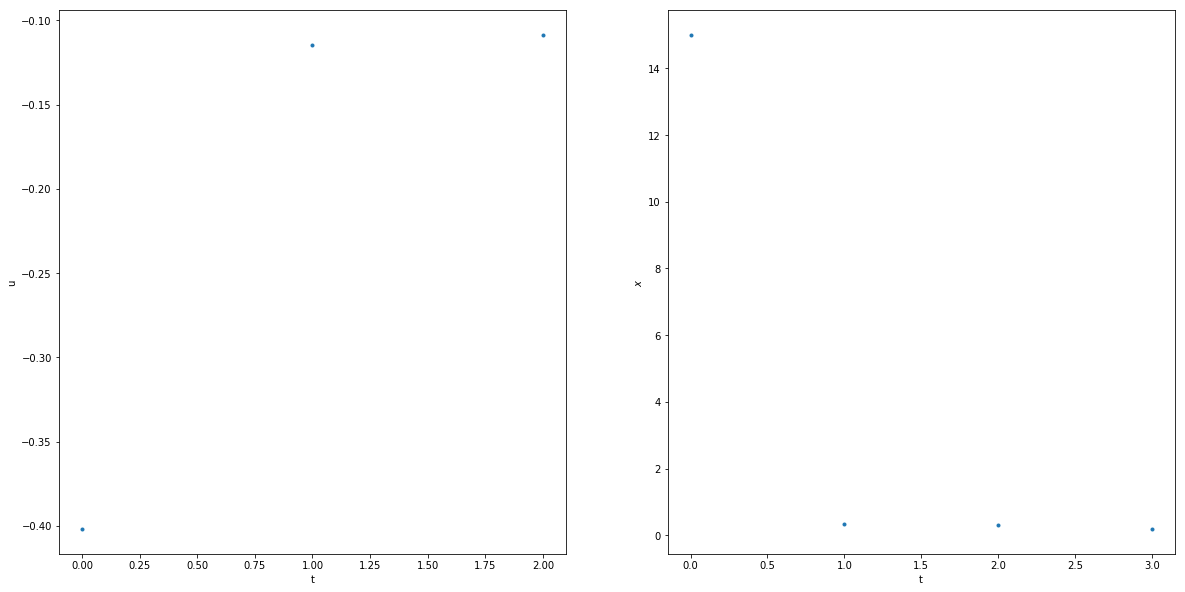

Approximate 1596.523099529648   Presize =  1596.4796778   Error =  -0.043421729648116525
u:  [-0.40184715577261243, -0.11469252113249835, -0.10859756350809885]
x:  [15.          0.33681473  0.2981846   0.18958703]
work time :     22.73


In [5]:
a = DiscreteSystem(4)
algorithm = SparrowSwarm(100, a.N_step, 10, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
algorithm.work(a)

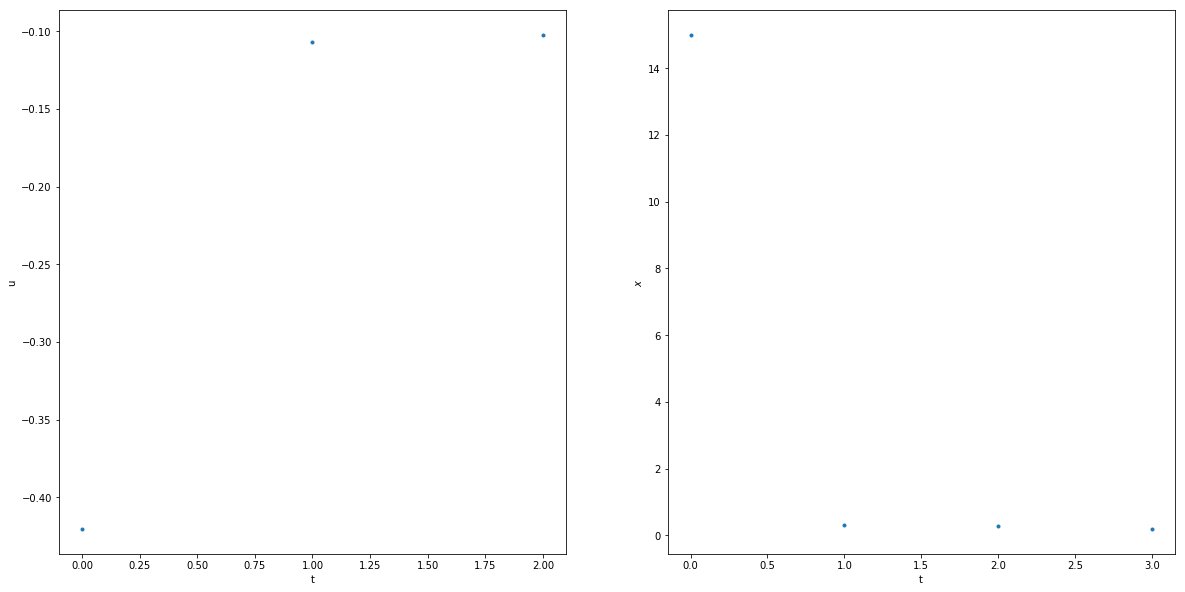

Approximate 1596.4914665748909   Presize =  1596.4796778   Error =  -0.011788774890874265
[-0.420539705173856, -0.10671671265917422, -0.10229075817545645]
work time :     14.31


In [47]:
a = DiscreteSystem(4)
algorithm = SparrowSwarm(70, a.N_step, 15, 10, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
algorithm.work(a)

DA

u:  [-0.4601435  -0.23977999  0.00740087]

x:  [15.          0.28762674  0.2186596   0.22606047]


SCO

u:  [-0.43793789401390887, -0.10866476711357158, 0.0]

x:  [15.          0.30545348  0.27226144  0.27226144]